# 1. Classification Modelling

## Overview
In this phase, we already have our dataset completely prepared and normalized, ready to be applied into classification algorithms. We'll first split our dataset and leave aside 20% of our data, to be tested only in the end of this process, after training a few different classification models. The one with best performance in this final test dataset will be our best model.

## Load pre-processed dataset

In [106]:
#All imports here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import grid_search


%matplotlib inline

In [3]:
startups = pd.read_csv('data/startups_pre_processed.csv', index_col=0)
startups[:3]

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,Category_Software,Category_Biotechnology,Category_Mobile,Category_Enterprise Software,Category_E-Commerce,...,State_IL,State_PA,State_CO,State_VA,State_NJ,State_GA,State_OH,State_NC,State_MD,status
permalink,,,,,,,,,,,,,,,,,,,,,
/organization/-qounter,0.000023,0.055556,0.005917,0.002825,0.027344,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,operating
/organization/004-technologies,0.000000,0.000000,0.018409,0.002410,0.033203,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,operating
/organization/0xdata,0.001117,0.166667,0.015779,0.003906,0.001953,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,operating


## Define acquired status as our target variable

We are trying to forecast which startups are more likely to be acquired, so we are defining 'acquired' startups as 1 and the rest as 0. 

Also, in this phase, it was decided to remove from the dataset startups with status IPO, since they can be considered as successfull startups but that's not the point of this project.

In [4]:
startups = startups[startups['status'] != 'ipo']

In [5]:
startups['acquired'] = startups['status'].replace({'acquired':1, 'operating':0, 'closed':0})
startups = startups.drop('status', 1)

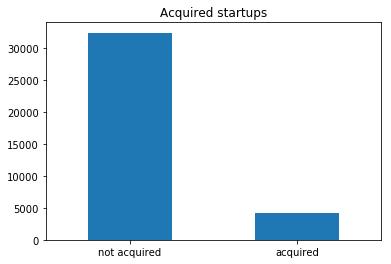

In [6]:
ax = startups['acquired'].replace({0:'not acquired', 1:'acquired'}).value_counts().plot(kind='bar', title="Acquired startups", rot=0)

## Train/Test Split
We'll now split the dataset, leaving the test dataset as it is in a real world observation ( imbalanced ).

In [7]:
dtrain, dtest = train_test_split(startups, test_size = 0.2, random_state=42, stratify=startups['acquired'])

## General model evualator
Let's define a helper function to train and evaluate models using GridSearchCV

In [8]:
def run_classifier(parameters, classifier, df):
    seed = 42
    np.random.seed(seed)
    X = df.iloc[:, :-1]
    y = df['acquired']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    clf = grid_search.GridSearchCV(classifier, parameters, n_jobs=-1, scoring='roc_auc', cv=5)
    clf.fit(X=X_train, y=y_train)
    model = clf.best_estimator_
    print ('Avg auc score: '+str(clf.best_score_), 'Best params: '+str(clf.best_params_))
    print 'Auc score on Train       set: {0:0.3f}'.format(roc_auc_score(y_train, model.predict(X_train)))
    print 'Auc score on Validation  set: {0:0.3f}'.format(roc_auc_score(y_test, model.predict(X_test)))
    cm = pd.crosstab(y_test, model.predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True)
    print 'FP rate: {0:0.1f}%'.format(cm[1][0]/float(cm['All'][0])*100)
    print 'TP rate: {0:0.1f}%'.format(cm[1][1]/float(cm['All'][1])*100)
    
    return model

## Random Forest

In [102]:
rf_parameters = {'max_depth':range(5,12), 'n_estimators': [50], 'class_weight':['balanced']}
rf_clf = run_classifier((rf_parameters), RandomForestClassifier(random_state=0), dtrain)

('Avg auc score: 0.858577560978', "Best params: {'n_estimators': 50, 'max_depth': 10, 'class_weight': 'balanced'}")
Auc score on Train       set: 0.827
Auc score on Validation  set: 0.777
FP rate: 18.1%
TP rate: 73.4%


## Principal Component Analysis

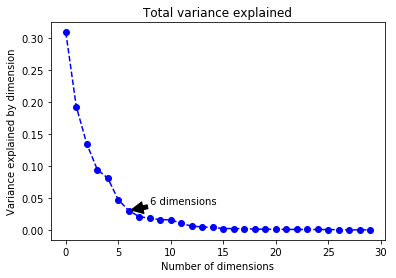

In [101]:
dtrain_numeric = dtrain.iloc[:, :-1].filter(regex=('(number_of|avg_).*|.*(funding_total_usd|funding_rounds|_at)'))
pca = PCA(n_components=30)

pca.fit(dtrain_numeric)

fig, ax = plt.subplots()
plt.plot(pca.explained_variance_ratio_, marker='o', color='b', linestyle='dashed')
ax.annotate('6 dimensions', xy=(6.2, pca.explained_variance_ratio_[6]+0.001), xytext=(8, 0.04),arrowprops=dict(facecolor='black', shrink=0.01),)
plt.title('Total variance explained')
plt.xlabel('Number of dimensions')
plt.ylabel('Variance explained by dimension')

We can notice that after the 6th dimension, the total variance explained by starts to get very low.

,Explained Variance,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,angel_funding_total_usd,angel_funding_rounds,convertible_note_funding_total_usd,convertible_note_funding_rounds,...,seed_funding_rounds,undisclosed_funding_total_usd,undisclosed_funding_rounds,venture_funding_total_usd,venture_funding_rounds,number_of_acquisitions,number_of_investments,number_of_unique_investments,number_of_investors_per_round,avg_amount_invested_per_round
Dimension 1,0.3086,0.0057,0.6335,0.0219,0.0100,-0.0785,0.0027,0.0048,0.0018,0.0124,...,-0.0182,0.0000,0.0040,0.0081,0.7098,0.0035,0.0002,0.0002,0.2492,0.0018
Dimension 2,0.1926,-0.0010,0.1700,-0.0511,-0.0169,-0.4192,0.0021,0.0325,0.0005,0.0177,...,0.8514,-0.0001,0.0023,-0.0019,-0.2211,-0.0016,-0.0001,-0.0001,0.1250,-0.0011
Dimension 3,0.1344,0.0000,-0.0982,0.0242,0.0264,0.6598,-0.0003,-0.0008,-0.0010,-0.0230,...,0.2412,0.0001,0.0048,0.0009,-0.0465,0.0013,0.0007,0.0007,0.5123,0.0014
Dimension 4,0.0944,0.0006,-0.0037,-0.0052,0.0095,0.2188,-0.0027,-0.0158,-0.0006,-0.0172,...,0.0738,0.0000,-0.0018,0.0017,-0.0065,0.0007,0.0008,0.0007,0.4422,0.0011
Dimension 5,0.0808,0.0001,-0.2442,-0.0470,-0.0254,-0.5645,-0.0013,-0.0182,0.0003,0.0105,...,-0.3600,0.0001,-0.0097,0.0004,-0.0895,-0.0010,0.0024,0.0023,0.6642,0.0016
Dimension 6,0.0473,0.0022,0.3201,0.0324,0.0064,0.0911,0.0293,0.1689,0.0029,0.0531,...,-0.1645,0.0008,0.0745,-0.0026,-0.4793,0.0005,0.0003,0.0003,0.1483,0.0010


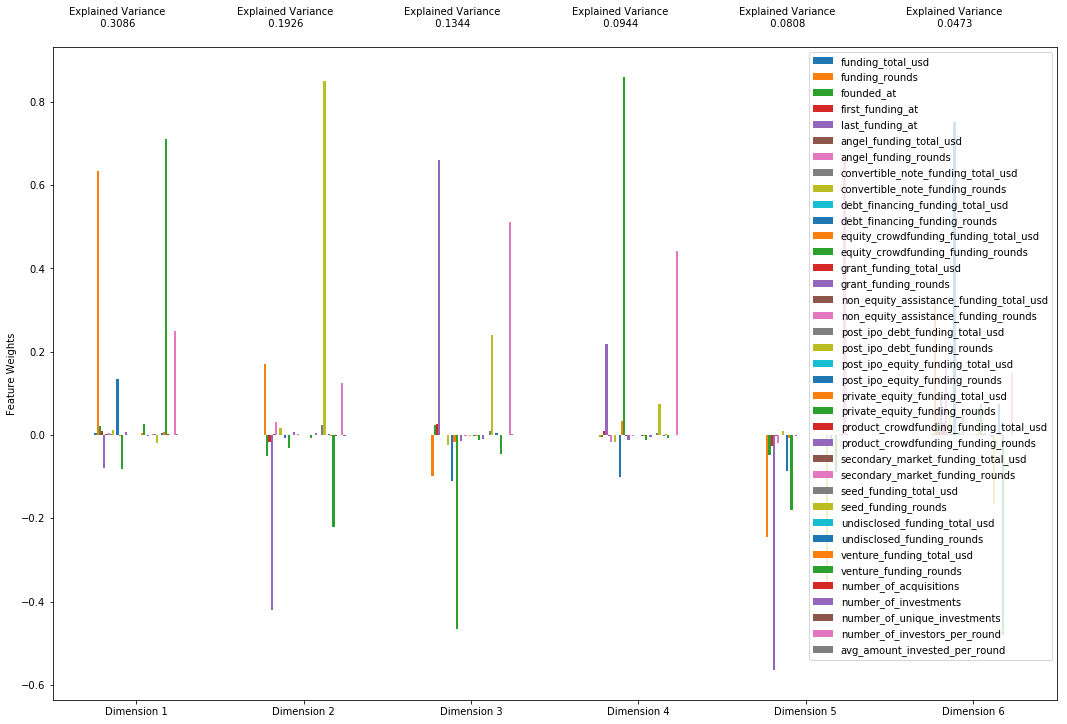

In [97]:
import sys
sys.path.insert(0, './exploratory_code')
import visuals as vs


pca = PCA(n_components=6)
pca.fit(dtrain_numeric)

# Generate PCA results plot
vs.pca_results(dtrain_numeric, pca)

With PCA, we can visualize the explained variance ratio of each dimension generated. From the chart above, we see, for example, a PCA transformation using only the numerical variables of our dataset. We see that the first dimension explains around 30% of the variance of the data. Most part of this percentage is explained by funding_rounds and venture_funding_rounds variables. For the second dimension, which explains 19% of the variance in the data, the most expressing features are last_funding_at and seed_fundind_rounds.

## Principal Component Analysis + Support Vector Machine

In [9]:
pca = PCA(n_components=6)
pca.fit(dtrain.iloc[:, :-1])
dtrain_pca =  pca.transform(dtrain.iloc[:, :-1])
dtrain_pca = pd.DataFrame(dtrain_pca)
dtrain_pca['acquired'] = list(dtrain['acquired'])

In [10]:
svm_parameters = [
  #{'C': [1, 10, 100], 'kernel': ['linear'], 'class_weight':['balanced']},
  {'C': [1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['rbf'], 'class_weight':['balanced']},
  #{'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 5], 'coef0':[0,1], 'class_weight':['balanced']},
 ]
svm_clf = run_classifier(svm_parameters, SVC(random_state=0), dtrain_pca)

('Avg auc score: 0.612707153638', "Best params: {'kernel': 'rbf', 'C': 100, 'gamma': 0.001, 'class_weight': 'balanced'}")
Auc score on Train       set: 0.576
Auc score on Validation  set: 0.567
FP rate: 39.1%
TP rate: 52.6%


## Only SVM

In [11]:
svm_parameters = [
  #{'C': [1, 10, 100], 'kernel': ['linear'], 'class_weight':['balanced']},
  {'C': [100], 'gamma': [0.001], 'kernel': ['rbf'], 'class_weight':['balanced']},
  #{'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 5], 'coef0':[0,1], 'class_weight':['balanced']},
 ]
svm_clf = run_classifier(svm_parameters, SVC(random_state=0), dtrain)

('Avg auc score: 0.830874595566', "Best params: {'kernel': 'rbf', 'C': 100, 'gamma': 0.001, 'class_weight': 'balanced'}")
Auc score on Train       set: 0.763
Auc score on Validation  set: 0.766
FP rate: 23.1%
TP rate: 76.4%


## k-Nearest Neighbors

In [12]:
knn_parameters = {'n_neighbors':[3, 5], 'n_jobs':[-1], 'weights':['distance', 'uniform']}
knn_clf = run_classifier(knn_parameters, KNeighborsClassifier(), dtrain)

('Avg auc score: 0.691067808096', "Best params: {'n_neighbors': 5, 'n_jobs': -1, 'weights': 'uniform'}")
Auc score on Train       set: 0.629
Auc score on Validation  set: 0.548
FP rate: 2.7%
TP rate: 12.3%


## k-Nearest Neighbors (subsampled)

In [13]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, return_indices=True)
X_undersampled, y_undersampled, indices = rus.fit_sample(dtrain.iloc[:, :-1], dtrain['acquired'])
dtrain_subsampled = pd.DataFrame(X_undersampled)
dtrain_subsampled['acquired'] = y_undersampled

In [14]:
knn_parameters = {'n_neighbors':[1, 10], 'n_jobs':[-1], 'weights':['distance', 'uniform']}
knn_subsampled_clf = run_classifier(knn_parameters, KNeighborsClassifier(), dtrain_subsampled)

('Avg auc score: 0.757172183278', "Best params: {'n_neighbors': 10, 'n_jobs': -1, 'weights': 'distance'}")
Auc score on Train       set: 1.000
Auc score on Validation  set: 0.701
FP rate: 30.1%
TP rate: 70.2%


## XGBoost

In [15]:
def model_xgboost_classifier(classifier, df, sample_weight={1:4,0:1}, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    seed = 42
    np.random.seed(seed)
    X = df.iloc[:, :-1]
    y = df['acquired']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    
    if useTrainCV:
        xgb_param = classifier.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=classifier.get_params()['n_estimators'], nfold=cv_folds, \
                          metrics='auc', early_stopping_rounds=early_stopping_rounds)
        classifier.set_params(n_estimators=cvresult.shape[0])
        print cvresult
    
    classifier.fit(X_train, y_train, eval_metric='auc', sample_weight=y_train.replace(sample_weight))
    
    print 'Auc score on Train       set: {0:0.3f}'.format(roc_auc_score(y_train, classifier.predict(X_train)))
    print 'Auc score on Validation  set: {0:0.3f}'.format(roc_auc_score(y_test, classifier.predict(X_test)))
    cm = pd.crosstab(y_test, classifier.predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True)
    print cm 
    print 'TP rate: {0:0.1f}%'.format(cm[1][0]/float(cm['All'][0])*100)
    print 'FP rate: {0:0.1f}%'.format(cm[1][1]/float(cm['All'][1])*100)
    
    return classifier

In [16]:
from xgboost import XGBClassifier

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=10,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 n_jobs=4,
 scale_pos_weight=1,
 random_state=0)

xgb_clf = model_xgboost_classifier(xgb1, dtrain, useTrainCV=False, cv_folds=5, early_stopping_rounds=1000)

Auc score on Train       set: 0.779
Auc score on Validation  set: 0.768
Predicted     0     1   All
True                       
0          4442   732  5174
1           214   451   665
All        4656  1183  5839
TP rate: 14.1%
FP rate: 67.8%


## Final test within unseen data

In [17]:
def compare_models(models, df):
    for var_model in models:
        model = eval(var_model)
        X = df.iloc[:, :-1]
        y = df['acquired']
        print '--------------'+var_model + '---------------'
        print 'Auc score on Test set: {0:0.3f}'.format(roc_auc_score(y, model.predict(X)))
        cm = pd.crosstab(y, model.predict(X), rownames=['True'], colnames=['Predicted'], margins=True)
        #print cm 
        print 'FP rate: {0:0.1f}%'.format(cm[1][0]/float(cm['All'][0])*100)
        print 'TP rate: {0:0.1f}%'.format(cm[1][1]/float(cm['All'][1])*100)
        

#compare_models(['rf_clf', 'svm_clf', 'knn_clf', 'knn_subsampled_clf'], dtest)
compare_models(['rf_clf', 'svm_clf', 'knn_clf', 'knn_subsampled_clf', 'xgb_clf'], dtest)

--------------rf_clf---------------
Auc score on Test set: 0.773
FP rate: 18.8%
TP rate: 73.4%
--------------svm_clf---------------
Auc score on Test set: 0.757
FP rate: 23.5%
TP rate: 74.8%
--------------knn_clf---------------
Auc score on Test set: 0.564
FP rate: 2.9%
TP rate: 15.6%
--------------knn_subsampled_clf---------------
Auc score on Test set: 0.665
FP rate: 32.8%
TP rate: 65.8%
--------------xgb_clf---------------
Auc score on Test set: 0.761
FP rate: 15.1%
TP rate: 67.4%


## Confusion Matrix visualization - Random Forest

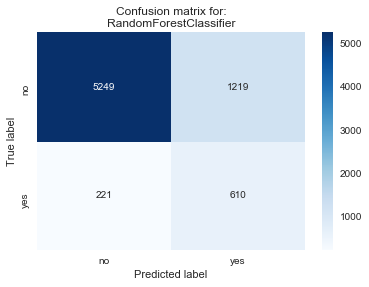

In [109]:
X = dtest.iloc[:, :-1]
y = dtest['acquired']

cm = confusion_matrix(y, rf_clf.predict(X))

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'], fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(rf_clf.__class__.__name__));

The chart above illustrates a concrete use case of our model and illustrastes as well the imbalance behavior in the test dataset. When classifying a dataset of 7299 companies, the model misclassified 1219 companies as they would be acquired but they were not. Similarly, it classified 610 companies as they would be acquired and they were, in fact, acquired. The results obtained in this project varied around this trade-off. Some models increased the accuracy of acquisitions suggestions, but at the same time, increased the missclassification of companies that should not be tagged positively. 